In [69]:
import pandas as pd 
import numpy as np
from forex_python.converter import CurrencyRates
import re
import matplotlib.pyplot as plt
import random
import seaborn as sns
from datetime import datetime, timedelta
import time
import os


import warnings
warnings.filterwarnings('ignore')



Expedia cleaning


In [70]:
Expedia_hotels = pd.read_csv(r"C:\Users\yarin\Data Science - College Of Management\Year 2\Semester 2\Data Science Fundementals\Final Project\DSF-final project\Notebooks\expedia\Expedia_hotels.csv")

In [71]:
expedia_df = Expedia_hotels.copy()

In [72]:
expedia_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Snapshot                45000 non-null  object 
 1   Index                   45000 non-null  int64  
 2   Hotel Name              45000 non-null  object 
 3   TTT                     45000 non-null  float64
 4   LOS                     45000 non-null  float64
 5   Grade                   44217 non-null  float64
 6   Num of Reviews          44217 non-null  object 
 7   Curr Price              45000 non-null  object 
 8   Original Price          20597 non-null  object 
 9   Percentage of discount  45000 non-null  float64
 10  Distance from center    45000 non-null  float64
 11  Type of room            45000 non-null  float64
 12  Location grade          45000 non-null  float64
 13  Is refundable           45000 non-null  bool   
 14  Late payment            45000 non-null

In [73]:
#taking only the date form the timestamp
expedia_df['Snapshot'] = expedia_df['Snapshot'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
#keep the firt 100 hotels in each search
expedia_df = expedia_df.loc[expedia_df['Index'] < 100].reset_index(drop=True)

#increase the index in one to avoid the 0 index
expedia_df['Index'] = expedia_df['Index'] + 1

#convert from float to int
expedia_df['TTT'] = expedia_df['TTT'].astype('int64')
expedia_df['LOS'] = expedia_df['LOS'].astype('int64')

In [74]:
#we can see that we have 6 hotels with no grade, we can check if they have reviews
expedia_df.loc[pd.isnull(expedia_df['Grade'])]['Hotel Name'].value_counts()

The FIDI Hotel                           222
Latisha luxury place                     173
The Flat NYC                             120
Moxy Brooklyn Willamsburg                115
The Ritz-Carlton New York, NoMad         108
Latisha house                             28
Lovely 2 Bedroom In Brooklyn Sleeps 5     16
Untitled at 3 Freeman Alley                1
Name: Hotel Name, dtype: int64

In [75]:
#we see that the hotels without grade have no reviews
expedia_df.loc[pd.isnull(expedia_df['Num of Reviews'])]['Hotel Name'].value_counts()

The FIDI Hotel                           222
Latisha luxury place                     173
The Flat NYC                             120
Moxy Brooklyn Willamsburg                115
The Ritz-Carlton New York, NoMad         108
Latisha house                             28
Lovely 2 Bedroom In Brooklyn Sleeps 5     16
Untitled at 3 Freeman Alley                1
Name: Hotel Name, dtype: int64

In [76]:
#keep only the digits
expedia_df['Num of Reviews'] = expedia_df['Num of Reviews'].apply(lambda x: int(re.sub("[^0-9]", "", x)) if not pd.isnull(x) else x)


In [77]:
#check how much hotels have only one review, that can tell us if the hotels without reviews are likely to have zero reviews
expedia_df.loc[expedia_df['Num of Reviews'] == 1].shape

(38, 17)

In [78]:
expedia_df['Num of Reviews'] = expedia_df['Num of Reviews'].fillna(0)

In [79]:
expedia_df['Grade'].describe()

count    44217.000000
mean         8.410114
std          0.644215
min          5.600000
25%          8.000000
50%          8.600000
75%          8.800000
max         10.000000
Name: Grade, dtype: float64

(array([  170.,   127.,   735.,  1732.,  2791., 10976., 11705., 11122.,
         4204.,   655.]),
 array([ 5.6 ,  6.04,  6.48,  6.92,  7.36,  7.8 ,  8.24,  8.68,  9.12,
         9.56, 10.  ]),
 <BarContainer object of 10 artists>)

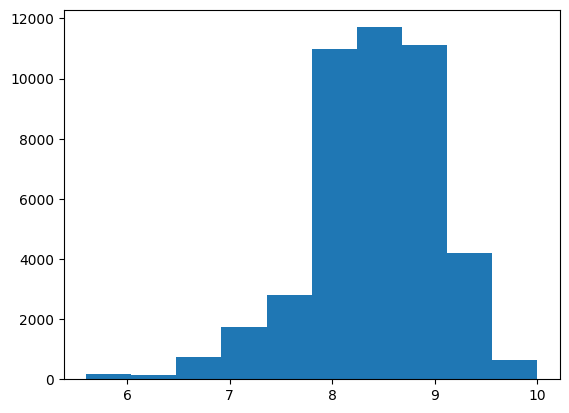

In [80]:
#lets see the histogram of the grades
plt.hist(expedia_df['Grade'])


In [81]:
#we choose to fill the missing values with a random number between 5 and 6 - whiche means that the hotel has a low grade
expedia_df['Grade'] = expedia_df['Grade'].fillna(round(random.uniform(5, 6),1))


In [82]:
expedia_df['Curr Price'] = expedia_df['Curr Price'].apply(lambda x: x.split('€')[1])

In [83]:
expedia_df['Original Price'] = expedia_df['Original Price'].apply(lambda x: x.split('€')[1] if not pd.isnull(x) else x)



In [84]:
expedia_df['Original Price']

0          360
1          NaN
2          493
3          NaN
4          NaN
         ...  
44995    2,352
44996    1,789
44997      NaN
44998      NaN
44999    1,583
Name: Original Price, Length: 45000, dtype: object

In [85]:
#fill the original price with the current price if it is missing
expedia_df['Original Price'] = expedia_df.apply(lambda x: x['Curr Price']  if pd.isnull(x['Original Price']) else x['Original Price'], axis = 1)
expedia_df['Original Price']

0          360
1          217
2          493
3          328
4          428
         ...  
44995    2,352
44996    1,789
44997    2,091
44998    1,816
44999    1,583
Name: Original Price, Length: 45000, dtype: object

In [86]:
#convert the prices to int
expedia_df['Original Price'] = expedia_df['Original Price'].apply(lambda x: int(x.replace(',','')))
expedia_df['Curr Price'] = expedia_df['Curr Price'].apply(lambda x: int(x.replace(',','')))

In [87]:
expedia_df['Original Price']  


0         360
1         217
2         493
3         328
4         428
         ... 
44995    2352
44996    1789
44997    2091
44998    1816
44999    1583
Name: Original Price, Length: 45000, dtype: int64

In [88]:
#create dictionary with the exchange rate for each date
c = CurrencyRates()
x = expedia_df['Snapshot'].unique()
curr_dict = {}
for date in x:
    curr_dict[date] = c.get_rate('EUR','USD', date) 

In [89]:
curr_dict[expedia_df['Snapshot'].loc[0]]

1.0929

In [90]:
expedia_df[['Original Price','Curr Price']]

,Original Price,Curr Price
0,360,278
1,217,217
2,493,449
3,328,328
4,428,428
...,...,...
44995,2352,1908
44996,1789,1373
44997,2091,2091
44998,1816,1816


In [91]:
#multiply the prices by the exchange rate and divide by the LOS to get price per night
expedia_df['Original Price'] = expedia_df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)
expedia_df['Curr Price'] = expedia_df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)


In [92]:
expedia_df['Original Price'] = expedia_df['Original Price'].apply(lambda x: round(x,1))
expedia_df['Curr Price'] = expedia_df['Curr Price'].apply(lambda x: round(x,1))

In [93]:
expedia_df[['Original Price','Curr Price']]

,Original Price,Curr Price
0,393.4,303.8
1,237.2,237.2
2,538.8,490.7
3,358.5,358.5
4,467.8,467.8
...,...,...
44995,521.4,423.0
44996,396.6,304.4
44997,463.5,463.5
44998,402.6,402.6


In [94]:
#drop unrelevant columns
expedia_df.drop(['Percentage of discount', 'Distance from center', 'Type of room',
       'Location grade'], axis = 1, inplace=True)

In [95]:
#convert the columns to int

expedia_df[['Is refundable','Late payment', 'Option Member']] = expedia_df[['Is refundable','Late payment', 'Option Member']].astype('int64')


In [96]:
expedia_df['Extras included'] = expedia_df['Extras included'].apply(lambda x: 1 if not pd.isnull(x) else 0)


In [97]:
expedia_df['Percent of discount'] = expedia_df.apply(lambda x: 1 - (x['Curr Price']/x['Original Price'])  , axis = 1)
expedia_df['Percent of discount'] = expedia_df['Percent of discount'].apply(lambda x: round(x,2))

In [98]:
expedia_df =expedia_df[['Snapshot', 'Index', 'Hotel Name', 'TTT', 'LOS', 'Grade',
       'Num of Reviews', 'Curr Price', 'Original Price','Percent of discount', 'Is refundable',
       'Late payment', 'Extras included', 'Option Member']]

In [99]:
expedia_df.head(10)


,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Percent of discount,Is refundable,Late payment,Extras included,Option Member
0,2022-03-06,1,Hotel 32 32,1,1,8.0,1296.0,303.8,393.4,0.23,0,0,0,0
1,2022-03-06,2,Sonesta Simply Suites Jersey City,1,1,8.4,1002.0,237.2,237.2,0.00,1,0,0,0
2,2022-03-06,3,Park Lane New York,1,1,8.8,305.0,490.7,538.8,0.09,0,0,0,0
3,2022-03-06,4,Arlo Midtown,1,1,9.2,3123.0,358.5,358.5,0.00,1,0,0,1
4,2022-03-06,5,"PUBLIC, an Ian Schrager hotel",1,1,8.0,1465.0,467.8,467.8,0.00,0,0,0,1
5,2022-03-06,6,Hard Rock Hotel New York,1,1,9.2,716.0,592.4,592.4,0.00,1,0,0,1
6,2022-03-06,7,Hotel Edison Times Square,1,1,7.8,2758.0,279.8,279.8,0.00,1,0,1,1
7,2022-03-06,8,YOTEL New York Times Square,1,1,7.0,1889.0,240.4,262.3,0.08,0,0,0,1
8,2022-03-06,9,Moxy Brooklyn Willamsburg,1,1,6.0,0.0,264.5,264.5,0.00,0,0,0,0
9,2022-03-06,10,New York Marriott Marquis,1,1,9.0,1543.0,588.0,588.0,0.00,0,0,0,0


In [100]:
expedia_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Snapshot             45000 non-null  object 
 1   Index                45000 non-null  int64  
 2   Hotel Name           45000 non-null  object 
 3   TTT                  45000 non-null  int64  
 4   LOS                  45000 non-null  int64  
 5   Grade                45000 non-null  float64
 6   Num of Reviews       45000 non-null  float64
 7   Curr Price           45000 non-null  float64
 8   Original Price       45000 non-null  float64
 9   Percent of discount  45000 non-null  float64
 10  Is refundable        45000 non-null  int64  
 11  Late payment         45000 non-null  int64  
 12  Extras included      45000 non-null  int64  
 13  Option Member        45000 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 4.8+ MB


Expedia EDA

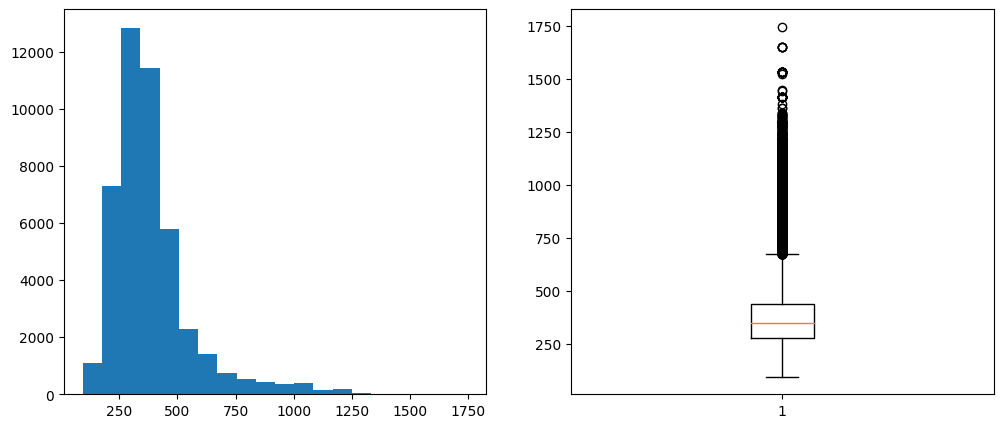

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(expedia_df['Curr Price'], bins=20)
ax2.boxplot(expedia_df['Curr Price'])
plt.show()

In [102]:
expedia_q1=expedia_df['Curr Price'].quantile(0.25)
expedia_q3=expedia_df['Curr Price'].quantile(0.75)

price_IQR = expedia_q3-expedia_q1

prices_lower_limit = expedia_q1 - (1.5 * price_IQR)
prices_upper_limit = expedia_q3 + (1.5 * price_IQR)

price_filter = expedia_df['Curr Price'].apply(lambda x: x > prices_lower_limit and x < prices_upper_limit)

expedia_df = expedia_df.loc[price_filter].reset_index(drop=True)


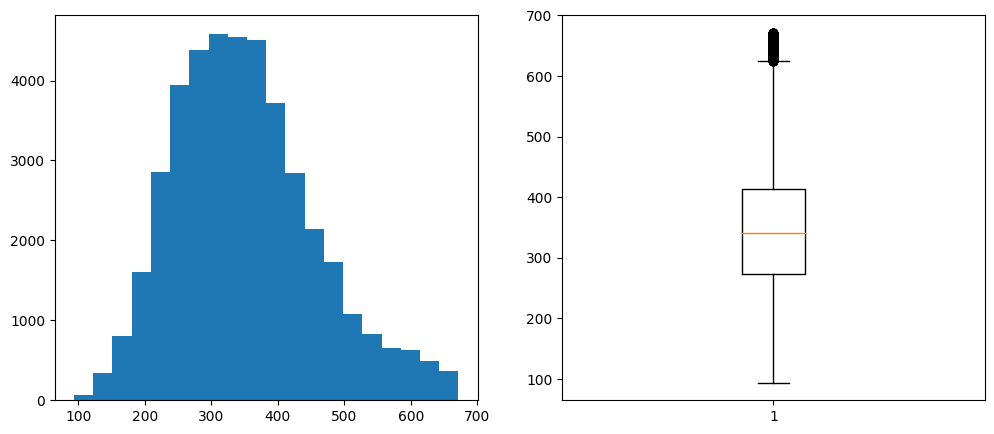

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.hist(expedia_df['Curr Price'], bins=20)
ax2.boxplot(expedia_df['Curr Price'])
plt.show()

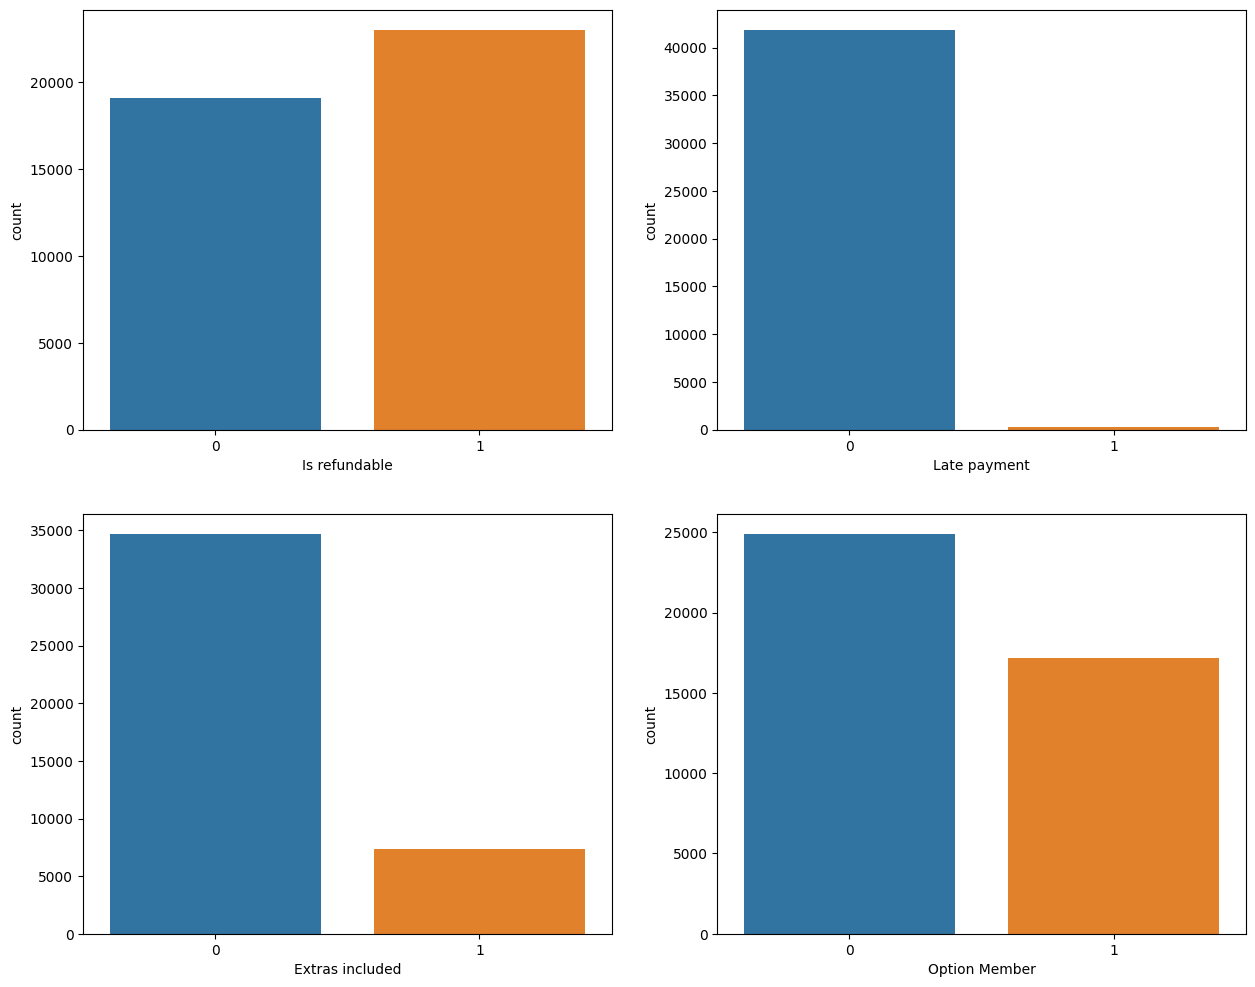

In [104]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(expedia_df.columns[10:],axes.flatten()):
    sns.countplot(data=expedia_df,x=col,ax=ax)

ניתן לראות שכמות המלונות שמאפשרים תשלום מאוחר וכמות המלונות שיש להם אקסטרות היא קטנה ביחס לכמות המלונות ללא תשלום מאוחר וללא אקסטרות 

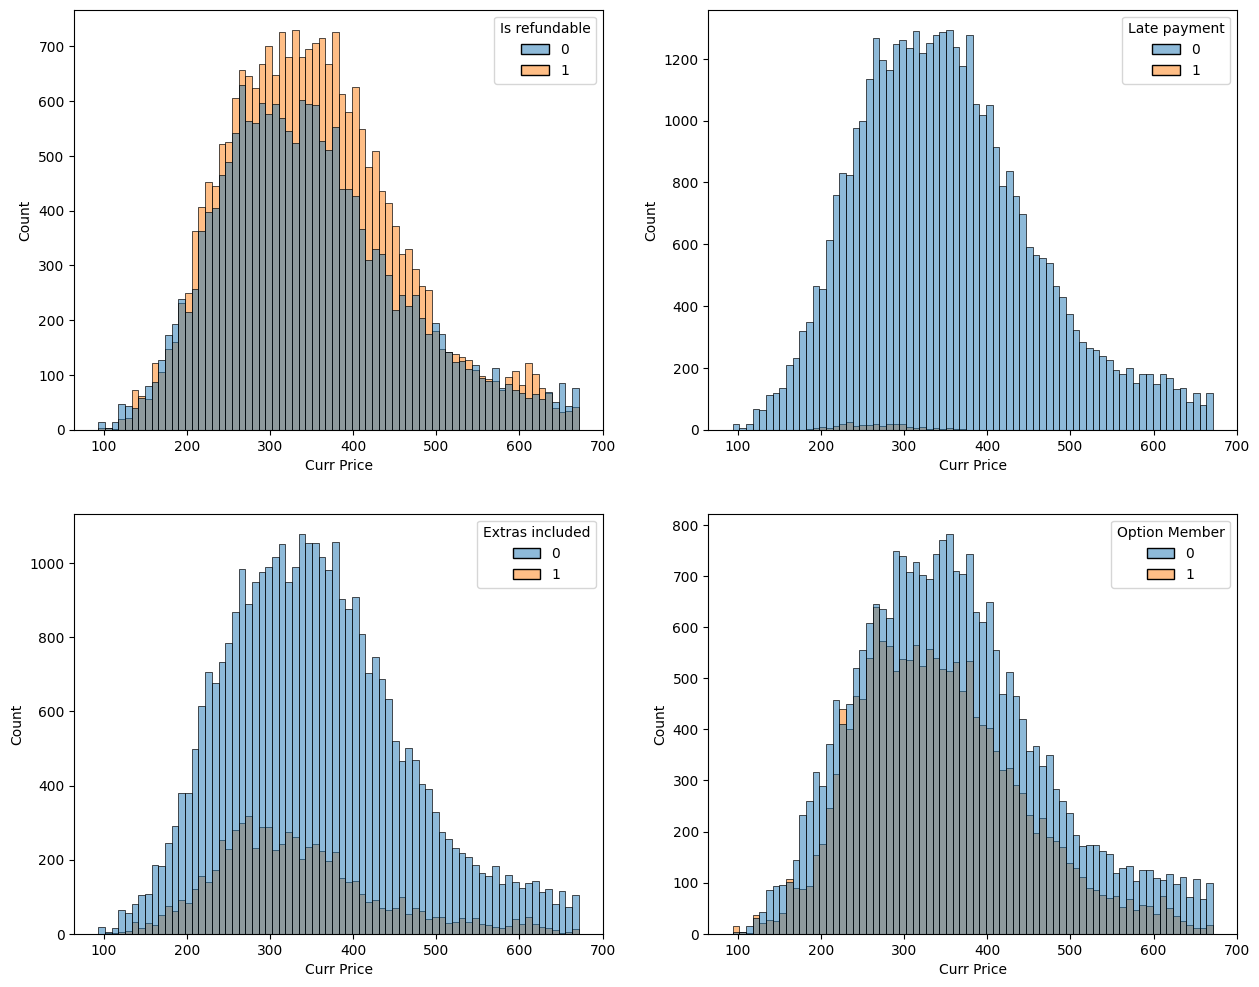

In [105]:
fig,axes = plt.subplots(2,2,figsize=(15,12))
for col,ax in zip(expedia_df.columns[10:],axes.flatten()):
    sns.histplot(data=expedia_df,x='Curr Price',ax=ax,hue = col)

מכאן ניתן להסיק שאין הבדל בהתפלגות המחירים בין הקטגוריות של העמודות הנ"ל , לכן העמודות יהיו פחות רלוונטיות כשמדובר במודלים כמו עץ/רנדום פורסט 

,count,mean,std,min,25%,50%,75%,max
Grade,42111.0,8.326162,0.695806,5.6,8.0,8.4,8.80,10.00
Num of Reviews,42111.0,1067.369286,662.631464,0.0,998.0,1003.0,1156.00,6080.00
Curr Price,42111.0,351.212379,106.608677,93.7,273.0,340.5,413.90,671.40
Original Price,42111.0,381.314212,129.883768,93.7,290.8,362.7,449.30,1357.70
Percent of discount,42111.0,0.066559,0.087376,0.0,0.0,0.0,0.13,0.51


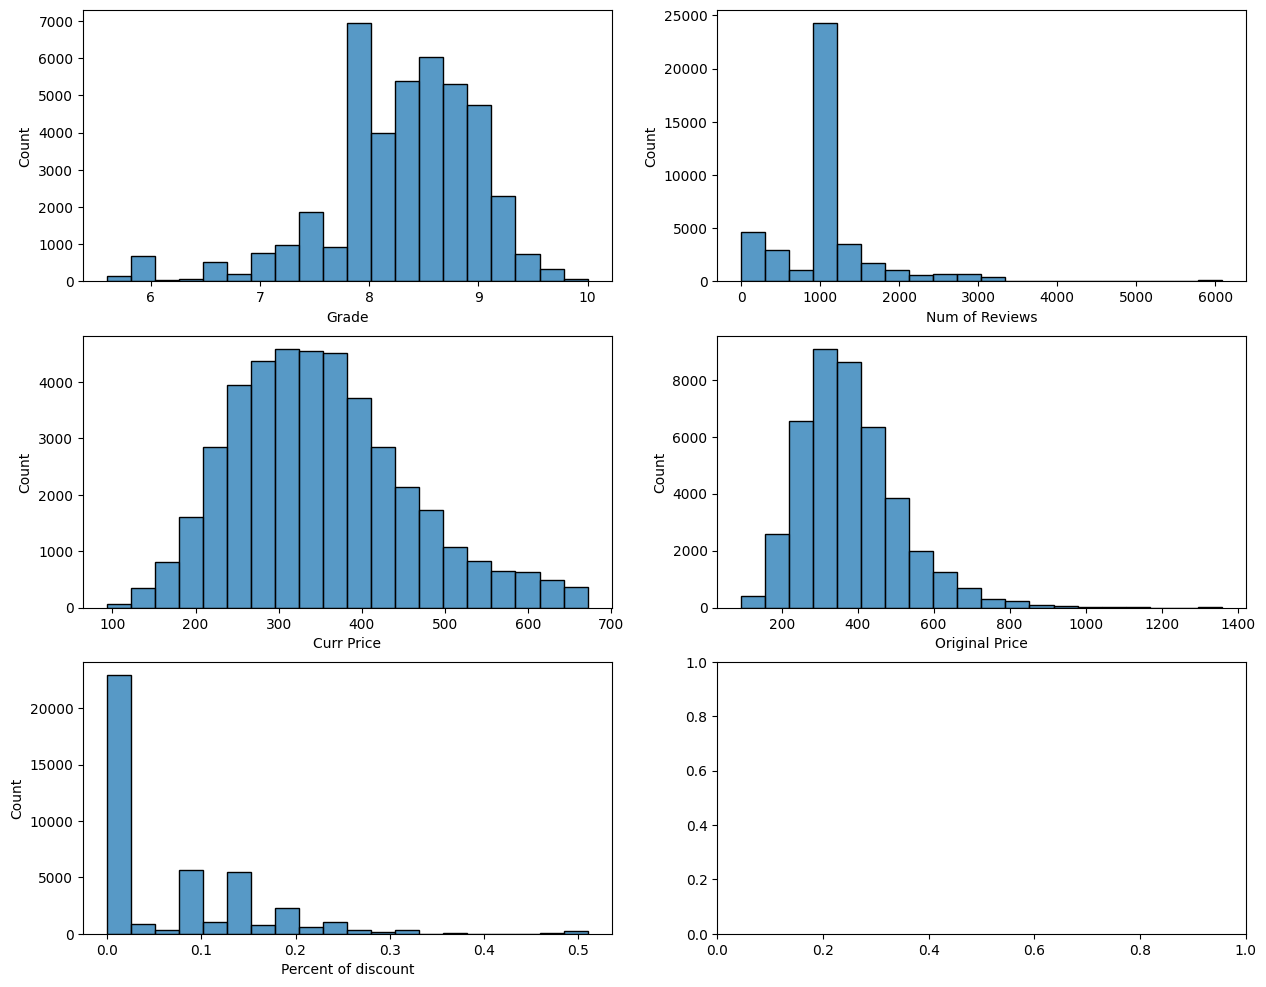

In [106]:
cols = expedia_df.columns[5:10]
fig,axes = plt.subplots(3,2,figsize=(15,12))
for col,ax in zip(cols,axes.flatten()):
    sns.histplot(data=expedia_df,x=col,ax=ax, bins=20)
    
expedia_df[cols].describe().T

לגבי עמודות המחירים - ניתן לראות שבמידה ונוריד את הערכים החריגים נקבל התפלגות די נורמאלית
לגבי אחוזי ההנחה - ניתן לראות שיותר מחצי מהמלונות ללא הנחה
לגבי ציוני המלונות - ניתן לראות שעיקר המלונות הם בין ציון 8 ל9
לגבי מספר התגובות - רוב המלונות עם כ1000 תגובות

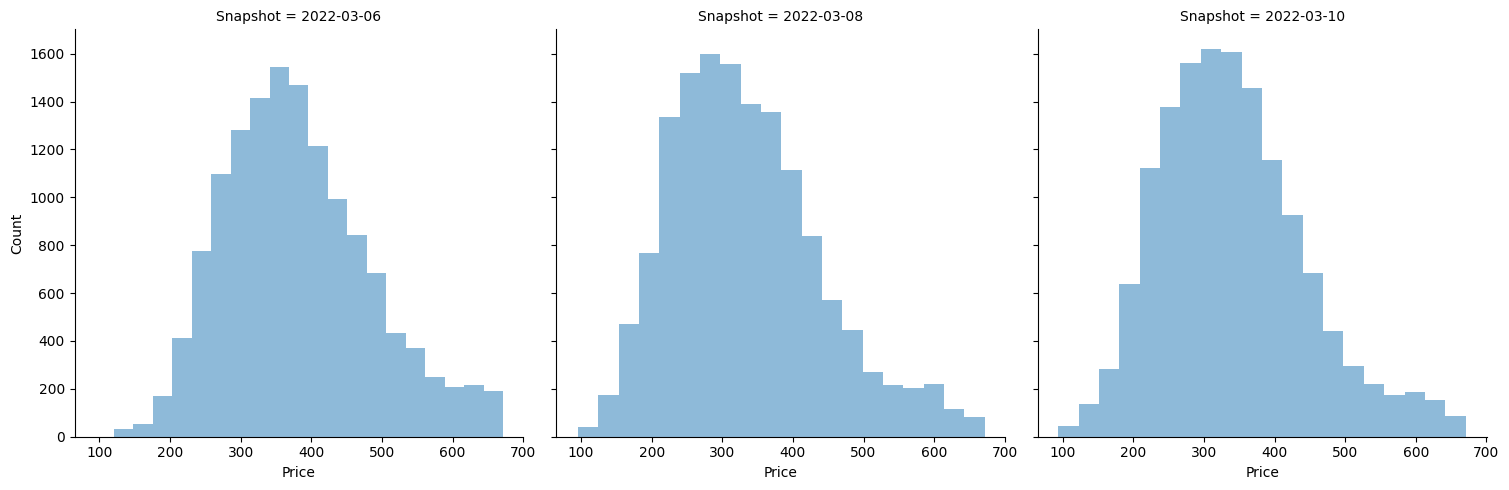

,count,mean,std,min,25%,50%,75%,max
Snapshot,,,,,,,,
2022-03-06,13655.0,380.753958,103.706898,120.6,304.6,369.4,444.1,671.4
2022-03-08,14295.0,333.612718,106.347612,95.8,256.0,320.2,395.4,671.3
2022-03-10,14161.0,340.492578,103.645614,93.7,265.6,329.6,401.2,670.6


In [107]:
# Create a FacetGrid with three histograms
g = sns.FacetGrid(expedia_df, col='Snapshot', height=5, aspect=1)
g = g.map(plt.hist, 'Curr Price', alpha=0.5, bins=20)

# Add labels to the plot
g.set_axis_labels('Price', 'Count')
plt.show()

expedia_df.groupby('Snapshot')['Curr Price'].describe()


למרות שהתאריך הראשון בעל ממוצע וחציון יותר גבוהים במחירים, ניתן להסיק כי אין הבדל משמעותי בין שלושת התאריכים ומכאן שלא תהיה משמעות להפוך את העמודה לאורדינאלית

In [108]:
expedia_df.replace({'Snapshot': {pd.datetime(2022,3,6).date() : 'Monday', pd.datetime(2022,3,8).date() : 'Wednesday', pd.datetime(2022,3,10).date() : 'Friday'}}, inplace=True)

In [109]:
expedia_df = expedia_df.join(pd.get_dummies(expedia_df['Snapshot']))


In [138]:
expedia_df.columns

Index(['Snapshot', 'Index', 'Hotel Name', 'TTT', 'LOS', 'Grade',
       'Num of Reviews', 'Curr Price', 'Original Price', 'Percent of discount',
       'Is refundable', 'Late payment', 'Extras included', 'Option Member',
       'Friday', 'Monday', 'Wednesday', 'Grade_cat'],
      dtype='object')

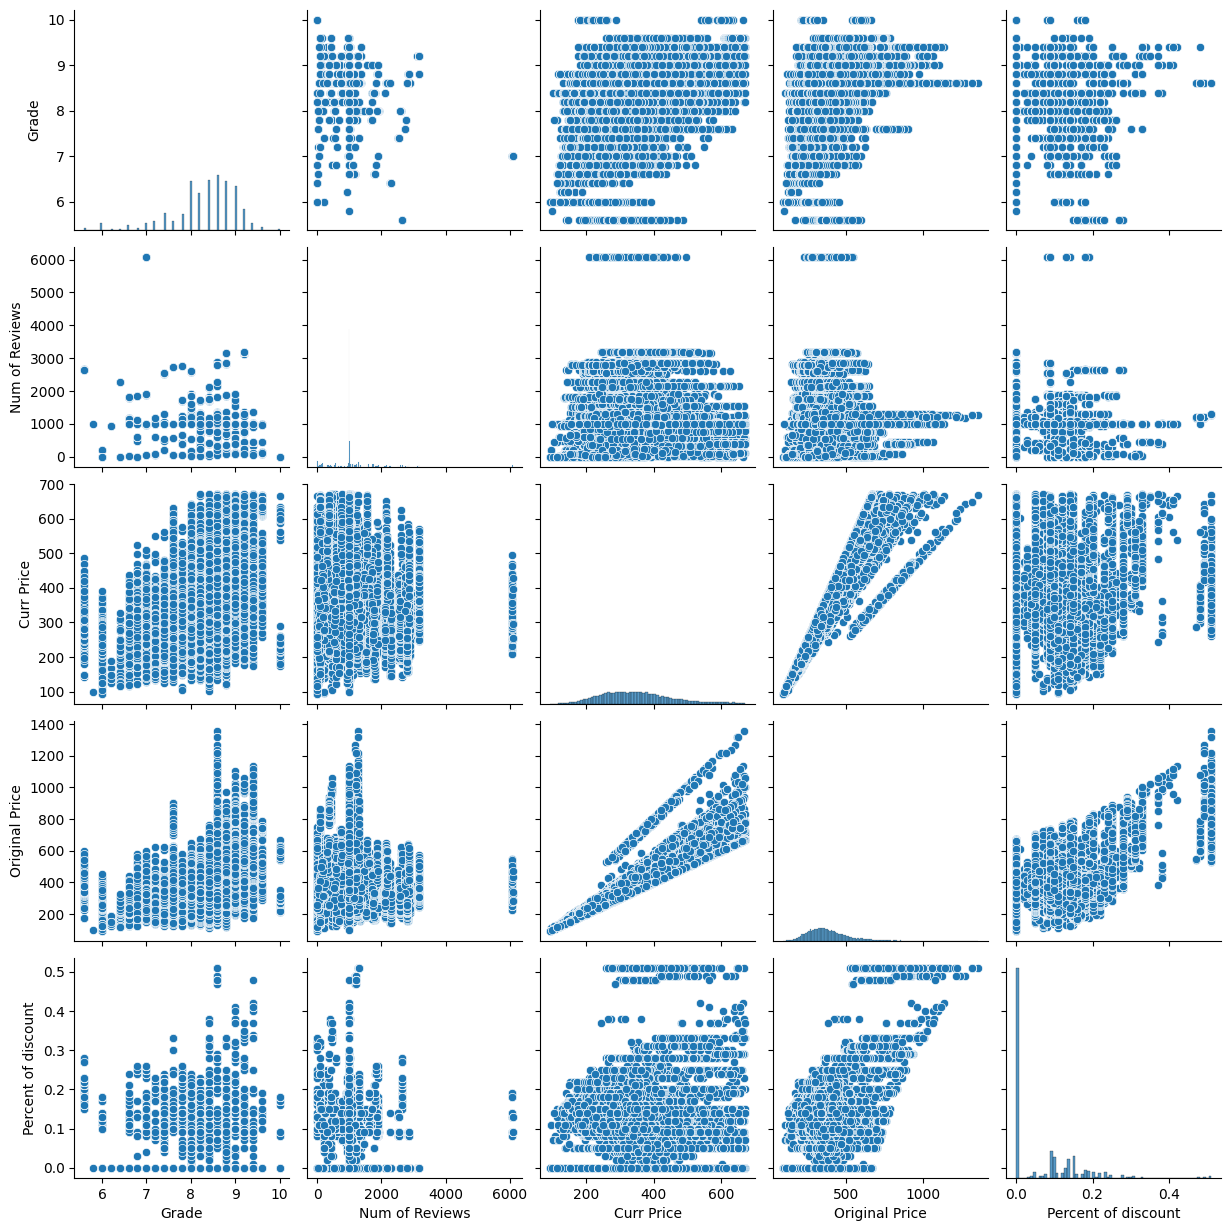

In [142]:
sns.pairplot(expedia_df.iloc[:,5:10])

<Axes: xlabel='TTT', ylabel='Curr Price'>

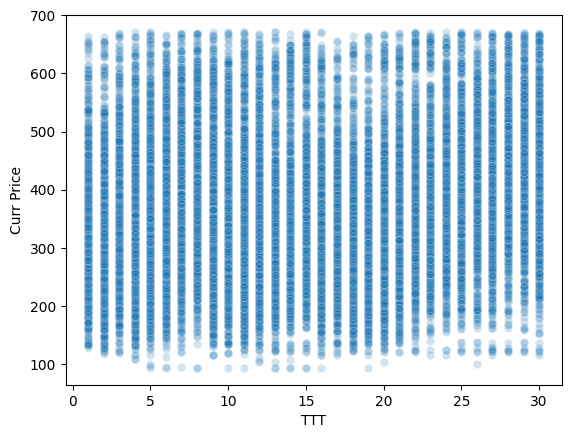

In [110]:
sns.scatterplot(data =expedia_df, x = 'TTT', y = 'Curr Price', alpha = 0.2)

העמודה לא ממש יוצרת הבדל במחירים, ככל שהימים שנותרו להזמנה קטנים יותר ניתן לראות יותר מלונות עם מחירים חריגים וגבוהים אבל אי אפשר להגדיר את זה כתבנית של הנתונים

,count,mean,std,min,25%,50%,75%,max
LOS,,,,,,,,
1,8476.0,336.482150,111.339989,94.2,251.60,323.50,404.4,671.0
2,8486.0,355.249776,109.168383,93.7,273.25,342.10,423.2,671.0
3,8390.0,355.757044,107.234879,93.8,277.00,344.30,418.2,671.4
4,8347.0,355.464107,103.733920,93.7,279.80,344.30,414.8,670.6
5,8412.0,353.230112,99.816510,93.8,281.40,345.65,410.6,669.0


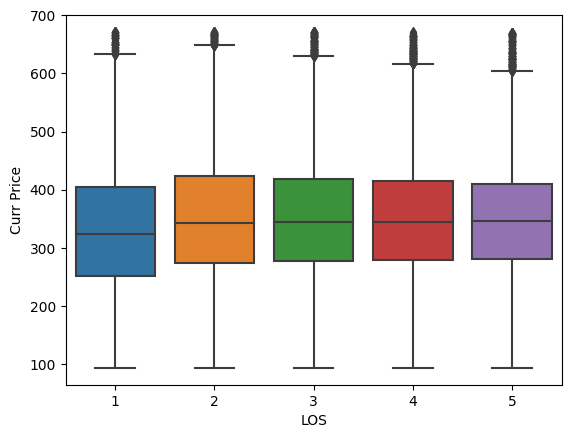

In [111]:
sns.boxplot(data =expedia_df, x = 'LOS', y = 'Curr Price')
expedia_df.groupby('LOS')['Curr Price'].describe()

כמות הלילות של ההזמנה לא משפיעה על המחיר ללילה של המלון

<Axes: xlabel='Index', ylabel='Curr Price'>

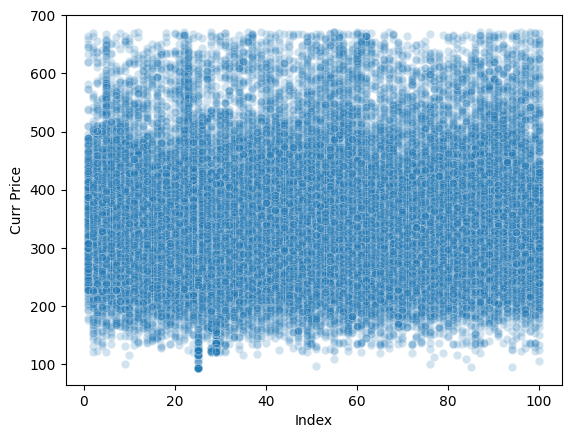

In [112]:
sns.scatterplot(data =expedia_df, x = 'Index', y = 'Curr Price', alpha = 0.2)

ניתן לראות שבדרך כלל במקומות הראשונים לא מוצגים המלונות היקרים

<Axes: xlabel='Num of Reviews', ylabel='Curr Price'>

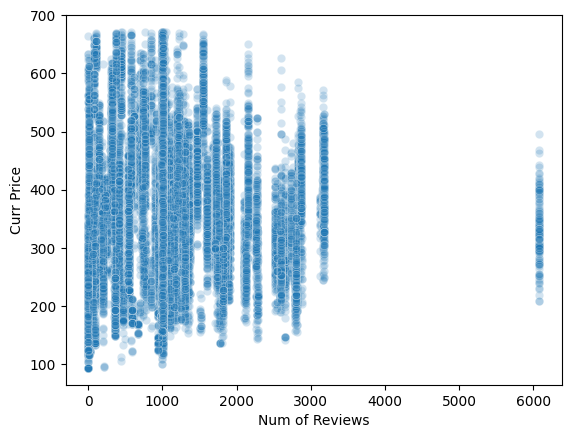

In [113]:
sns.scatterplot(data =expedia_df, x = 'Num of Reviews', y = 'Curr Price', alpha = 0.2)

רוב המלונות היקרים עם פחות תגובות מהממוצע - 1000 תגובות

<Axes: xlabel='Percent of discount', ylabel='Curr Price'>

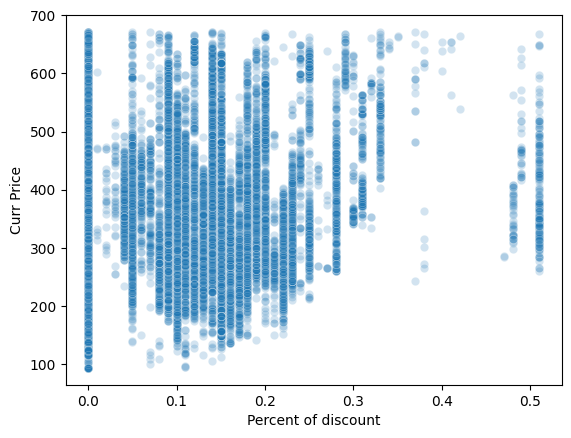

In [114]:
sns.scatterplot(data =expedia_df, x = 'Percent of discount', y = 'Curr Price', alpha = 0.2)

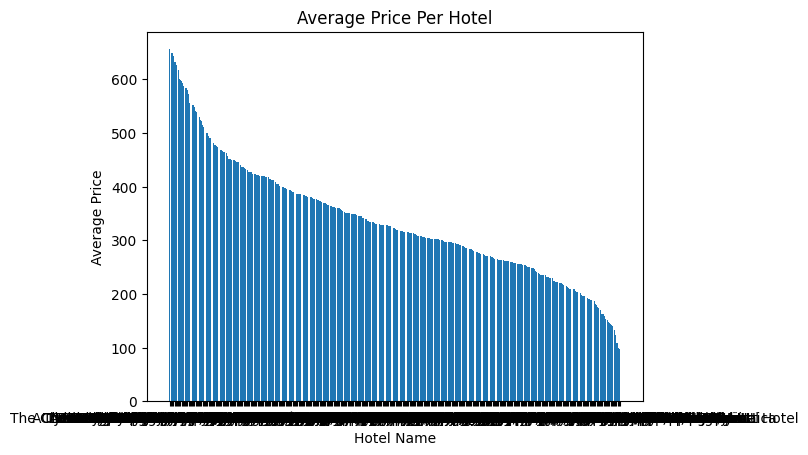

In [115]:
# Group data by hotel name and calculate mean price
avg_price_df = expedia_df.groupby('Hotel Name')['Curr Price'].mean()

# Sort by count of hotels
avg_price_df = avg_price_df.sort_values(ascending=False)

# Create bar graph of average price per hotel
plt.bar(avg_price_df.index, avg_price_df.values)
plt.xlabel('Hotel Name')
plt.ylabel('Average Price')
plt.title('Average Price Per Hotel')
plt.show()

<Axes: >

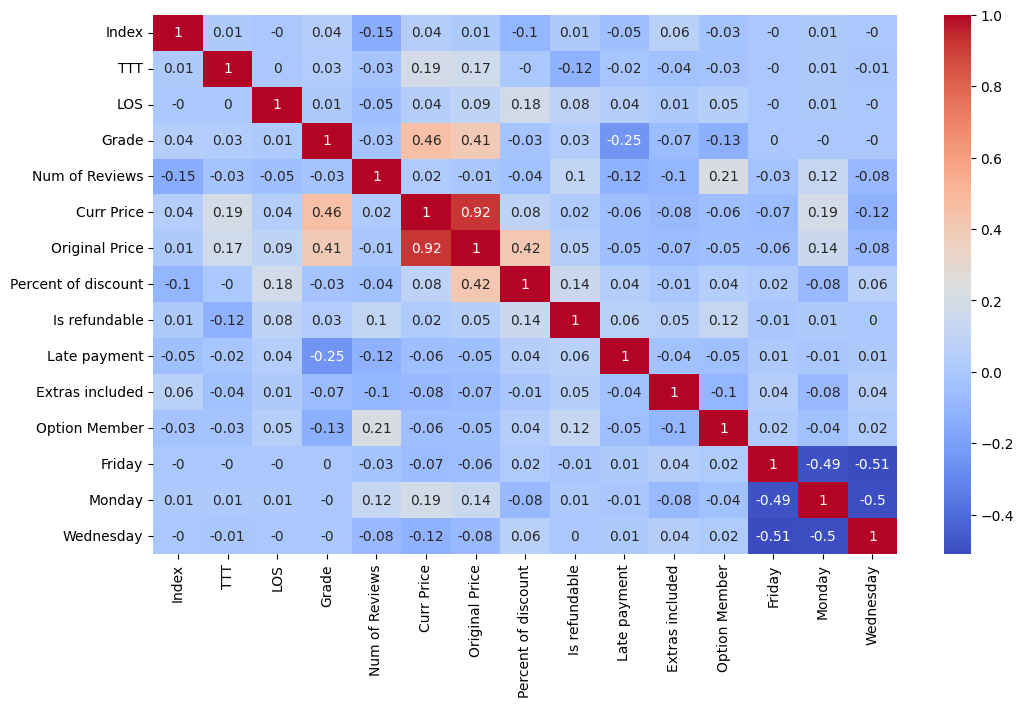

In [116]:
fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(expedia_df.corr().round(2), annot=True, ax=ax, cmap='coolwarm')

In [117]:
expedia_df.corr()['Curr Price'].sort_values(ascending=False)


Curr Price             1.000000
Original Price         0.923155
Grade                  0.462568
Monday                 0.191958
TTT                    0.191444
Percent of discount    0.077346
LOS                    0.044828
Index                  0.044578
Is refundable          0.018732
Num of Reviews         0.016228
Late payment          -0.062936
Option Member         -0.064408
Friday                -0.071574
Extras included       -0.081251
Wednesday             -0.118348
Name: Curr Price, dtype: float64

ניתן לראות שלציון המלון יש קורלציה גבוהה יחסית לשאר עם המחיר של המלון, לכן כדאי לדאוג שהדאתא של הלמידה ושל האימון יהיו מאוזנים ביחס לציון של המלונות

<Axes: xlabel='Grade', ylabel='Count'>

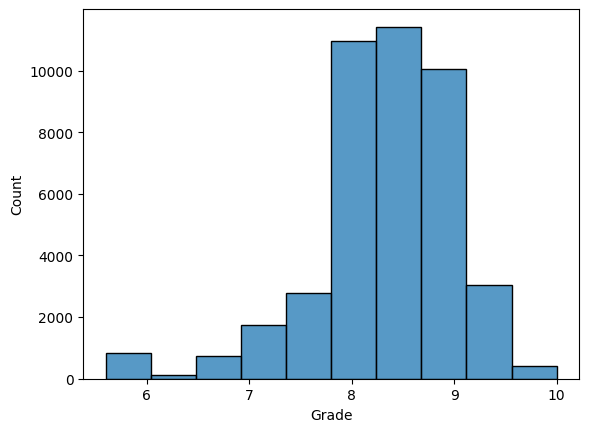

In [118]:
sns.histplot(data =expedia_df, x = 'Grade', bins=10)

ניתן לפצל את הדאתא לבינים לפי ההיסטוגרמה הנ"ל

<Axes: xlabel='Grade_cat', ylabel='Count'>

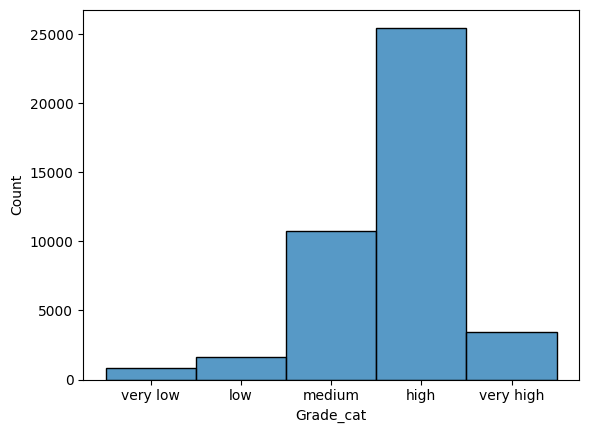

In [120]:
expedia_df['Grade_cat'] = pd.cut(expedia_df['Grade'], bins=[5,6,7, 8, 9,10], labels=['very low', 'low','medium', 'high', 'very high'])
sns.histplot(data =expedia_df, x = 'Grade_cat', bins=5)

In [131]:
from sklearn.model_selection import StratifiedShuffleSplit

def strat_split(df, col, test_size=0.3, random_state=42):
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(df, df[col]):
        strat_train_set = df.loc[train_index]
        strat_test_set = df.loc[test_index]
    return strat_train_set, strat_test_set

strat_train_set, strat_test_set = strat_split(expedia_df, 'Grade_cat')

In [132]:
strat_test_set["Grade_cat"].value_counts() / len(strat_test_set)


high         0.604797
medium       0.254551
very high    0.082080
low          0.038468
very low     0.020104
Name: Grade_cat, dtype: float64

In [133]:
expedia_df["Grade_cat"].value_counts() / len(expedia_df)


high         0.604759
medium       0.254565
very high    0.082116
low          0.038494
very low     0.020066
Name: Grade_cat, dtype: float64

דאגנו לכך שהחלק יחסי של קטגוריית ציון יהיה שווה גם באימון וגם בלמידה

In [144]:
expedia_df.drop('Grade_cat', axis=1, inplace=True)

In [ ]:
groups = expedia_df.groupby(['Snapshot']).reset_index(name='count')

# Create a histogram for each snapshot
for snapshot in groups['Snapshot'].unique():
    snapshot_data = groups[groups['Snapshot'] == snapshot]
    plt.hist(snapshot_data['Snapshot'], weights=snapshot_data['count'], bins=20, alpha=0.5, label=snapshot)

plt.legend(loc='upper right')
plt.xlabel('Price (USD)')
plt.ylabel('Hotel Count')
plt.show()

AttributeError: 'DataFrameGroupBy' object has no attribute 'reset_index'

In [143]:
expedia_df.head()

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Percent of discount,Is refundable,Late payment,Extras included,Option Member,Friday,Monday,Wednesday,Grade_cat
0,Monday,1,Hotel 32 32,1,1,8.0,1296.0,303.8,393.4,0.23,0,0,0,0,0,1,0,medium
1,Monday,2,Sonesta Simply Suites Jersey City,1,1,8.4,1002.0,237.2,237.2,0.00,1,0,0,0,0,1,0,high
2,Monday,3,Park Lane New York,1,1,8.8,305.0,490.7,538.8,0.09,0,0,0,0,0,1,0,high
3,Monday,4,Arlo Midtown,1,1,9.2,3123.0,358.5,358.5,0.00,1,0,0,1,0,1,0,very high
4,Monday,5,"PUBLIC, an Ian Schrager hotel",1,1,8.0,1465.0,467.8,467.8,0.00,0,0,0,1,0,1,0,medium


booking cleaning

In [ ]:
df = pd.read_csv(r"C:\Users\royzo\DS-project\Notebooks\Booking\Booking_hotels.csv")


In [ ]:
df.head()


,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Extra Data
0,2023-03-06 11:24:01.241227,1,Margaritaville Resort Times Square,0,1,8.8,"1,369 reviews",₪ 752,₪ 752,1.5 km from center,Standard Queen Room,Location 9.4,Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...
1,2023-03-06 11:24:01.241227,2,33 Seaport Hotel New York,0,1,8.6,284 reviews,"₪ 1,050\r\nPrice ₪ 1,050","₪ 1,050\r\nPrice ₪ 1,050",6.9 km from center,Superior Courtyard King,NaN,Superior Courtyard King\r\n1 king bed
2,2023-03-06 11:24:01.241227,3,The Belvedere Hotel,0,1,8.0,"3,644 reviews",₪ 510,₪ 510,0.9 km from center,Standard King Room,Location 9.4,Standard King Room\r\n1 king bed\r\nOnly 2 roo...
3,2023-03-06 11:24:01.241227,4,CIVILIAN Hotel,0,1,8.5,"1,172 reviews",₪ 767,₪ 767,0.9 km from center,Double Room,Location 9.5,Double Room\r\n1 queen bed
4,2023-03-06 11:24:01.241227,5,The Cloud One New York-Downtown,0,1,8.2,518 reviews,₪ 620,₪ 620,7 km from center,Standard King Room,NaN,Standard King Room\r\n1 king bed\r\nFREE cance...


In [ ]:
# extracting numeric data and removing useless text from prices, location grade, and review. normalize distance from center to m' instead of km, and inserts -1 instead of NaNs

df = pd.read_csv(r"C:\Users\royzo\DS-project\Notebooks\Booking\Booking_hotels.csv")
df[['del', 'Curr Price']] = df['Curr Price'].str.split(' ', 1, expand = True)
df[['Curr Price','del2']] = df['Curr Price'].str.split(r"\r", 0, expand = True)
df[['del', 'Original Price']] = df['Original Price'].str.split(' ', 1, expand = True)
df[['Original Price','del2']] = df['Original Price'].str.split(r"\r", 0, expand = True)
df[['Num of Reviews', 'del']] = df['Num of Reviews'].str.split(' ', 1, expand = True)

df['Distance from center'] = df['Distance from center'].apply(lambda a: int(float(a.split(' ')[0])*1000) if a.split(' ')[1] == 'km' else int(a.split(' ')[0]))
df[['del', 'Location grade']] = df['Location grade'].str.split(' ', 1, expand = True)
df['Location grade'] = df['Location grade'].apply(lambda a: -1 if pd.isna(a) else a)

df = df.drop(columns=['del', 'del2'])

In [ ]:
# from datetime to date

df['Snapshot'] = pd.to_datetime(df['Snapshot']).dt.date
df

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Extra Data
0,2023-03-06,1,Margaritaville Resort Times Square,0,1,8.8,"1,369",752,752,1500,Standard Queen Room,9.4,Standard Queen Room\r\n1 queen bed\r\nOnly 1 r...
1,2023-03-06,2,33 Seaport Hotel New York,0,1,8.6,284,"1,050","1,050",6900,Superior Courtyard King,-1,Superior Courtyard King\r\n1 king bed
2,2023-03-06,3,The Belvedere Hotel,0,1,8.0,"3,644",510,510,900,Standard King Room,9.4,Standard King Room\r\n1 king bed\r\nOnly 2 roo...
3,2023-03-06,4,CIVILIAN Hotel,0,1,8.5,"1,172",767,767,900,Double Room,9.5,Double Room\r\n1 queen bed
4,2023-03-06,5,The Cloud One New York-Downtown,0,1,8.2,518,620,620,7000,Standard King Room,-1,Standard King Room\r\n1 king bed\r\nFREE cance...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2023-03-10,96,Aloft Manhattan Downtown - Financial District,29,5,7.5,"1,106","3,841","3,841",6800,"Guest room, 1 Queen",-1,"Guest room, 1 Queen\r\n1 queen bed\r\nFree can..."
44996,2023-03-10,97,Hampton Inn Manhattan/Downtown- Financial Dist...,29,5,7.6,658,"4,459","4,459",7700,Queen Room,-1,Queen Room\r\n1 queen bed\r\nFREE cancellation...
44997,2023-03-10,98,Leon Hotel LES,29,5,8.1,"1,309","5,398","6,748",5900,Superior Queen Room,-1,Superior Queen Room\r\n1 queen bed\r\nFREE can...
44998,2023-03-10,99,SoHo 54,29,5,6.9,"1,562","3,840","4,266",5300,SoHo King,-1,SoHo King\r\n1 king bed\r\nFREE cancellation •...


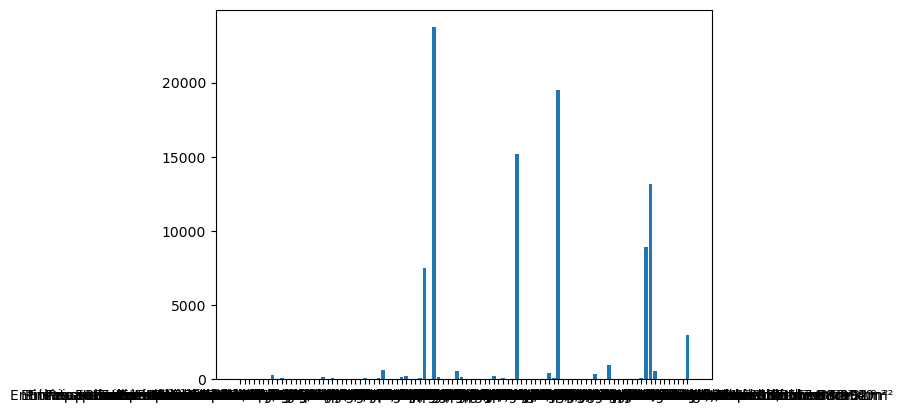

In [ ]:
#breaking down 'Extra Data' to categories

op_set = set()
#row = df.head(1)
for index, row in df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_set.add(item)

op_list = []
for index, row in df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    for item in line_list:
        op_list.append(item)

op_dict = {}
for set_item in op_set:
    count = 0
    for list_item in op_list:
        if list_item == set_item:
            count = count + 1
            
    op_dict[set_item] = count 

names = list(op_dict.keys())
values = list(op_dict.values())

plt.bar(range(len(op_dict)), values, tick_label=names)
plt.show()

In [ ]:
# focusing on top categories, ignoring bed count and other generic cats
sorted(op_dict.items(), key=lambda x: x[1], reverse=True)

[('FREE cancellation • No prepayment needed', 23734),
 ('1 king bed', 19514),
 ('You can cancel later, so lock in this great price today!', 15192),
 ('1 queen bed', 13172),
 ('Breakfast included', 8929),
 ('Free cancellation', 7520),
 ('1 full bed', 2975),
 ('2 full beds', 972),
 ('Private suite', 599),
 ('2 beds (1 king, 1 sofa bed)', 560),
 ('1 bunk bed', 558),
 ('2 twin beds', 455),
 ('2 queen beds', 354),
 ('Entire studio • 1 bathroom • 19m²', 317),
 ('Entire studio • 1 bathroom • 25m²', 239),
 ('2 beds (1 sofa bed, 1 queen)', 216),
 ('Entire studio • 1 bathroom • 325m²', 172),
 ('Entire studio • 1 bathroom • 18m²', 166),
 ('Entire studio • 1 bathroom • 20m²', 160),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 28m²', 138),
 ('1 twin bed', 115),
 ('Entire studio • 1 bathroom • 28m²', 96),
 ('Entire studio • 1 bathroom • 29m²', 65),
 ('Beds: 1 double or 2 twins', 64),
 ('Private suite • 1 bedroom • 1 living room • 1 bathroom • 30m²', 63),
 ('4 twin beds', 62),
 ('Entir

In [ ]:
# combining cats for free cancelation and comparing counts
cancellation_count = 0
for index, row in df.iterrows():
    line_list = row['Extra Data'].split('\r\n')[1:-1]
    if ('FREE cancellation • No prepayment needed' in line_list) or ('Free cancellation' in line_list):
        cancellation_count = cancellation_count + 1
        
print(cancellation_count)

df['Free Cancellation'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) 
                                                 or ('Free cancellation' in a.split('\r\n')) else False)
df.groupby('Free Cancellation').count()

31254


,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Extra Data
Free Cancellation,,,,,,,,,,,,,
False,13746,13746,13746,13746,13746,13746,13746,13746,13746,13746,13746,13746,13746
True,31254,31254,31254,31254,31254,31254,31254,31254,31254,31254,31254,31254,31254


In [ ]:
# converting top categories to bool

df['No prepayment needed'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('FREE cancellation • No prepayment needed' in a.split('\r\n')) else False)
df['Breakfast included'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('Breakfast included' in a.split('\r\n')) else False)
df['Cancel Later'] = df['Extra Data'].apply(lambda a: True if 
                                                 ('You can cancel later, so lock in this great price today!' in a.split('\r\n')) else False)
df = df.drop(columns=['Extra Data'])

In [ ]:
#converting ILS to USD for comparison to expedia
c = CurrencyRates()
x = df['Snapshot'].unique()
curr_dict = {}
for date in x:
    print()
    curr_dict[date] = c.get_rate('ILS','USD', date)


In [ ]:
df['Original Price'] = df['Original Price'].apply(lambda x: int(x.replace(',','')))
df['Curr Price'] = df['Curr Price'].apply(lambda x: int(x.replace(',','')))

In [ ]:
df['Original Price'] = df.apply(lambda x: (x['Original Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)
df['Curr Price'] = df.apply(lambda x: (x['Curr Price']*curr_dict[x['Snapshot']])/x['LOS']  , axis = 1)

In [ ]:
df

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Free Cancellation,No prepayment needed,Breakfast included,Cancel Later
0,2023-03-06,1,Margaritaville Resort Times Square,0,1,8.8,"1,369",210.251208,210.251208,1500,Standard Queen Room,9.4,False,False,False,False
1,2023-03-06,2,33 Seaport Hotel New York,0,1,8.6,284,293.568841,293.568841,6900,Superior Courtyard King,-1,False,False,False,False
2,2023-03-06,3,The Belvedere Hotel,0,1,8.0,"3,644",142.590580,142.590580,900,Standard King Room,9.4,False,False,False,False
3,2023-03-06,4,CIVILIAN Hotel,0,1,8.5,"1,172",214.445048,214.445048,900,Double Room,9.5,False,False,False,False
4,2023-03-06,5,The Cloud One New York-Downtown,0,1,8.2,518,173.345411,173.345411,7000,Standard King Room,-1,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2023-03-10,96,Aloft Manhattan Downtown - Financial District,29,5,7.5,"1,106",214.780556,214.780556,6800,"Guest room, 1 Queen",-1,True,False,False,True
44996,2023-03-10,97,Hampton Inn Manhattan/Downtown- Financial Dist...,29,5,7.6,658,249.337802,249.337802,7700,Queen Room,-1,True,True,False,True
44997,2023-03-10,98,Leon Hotel LES,29,5,8.1,"1,309",301.844686,377.333816,5900,Superior Queen Room,-1,True,True,False,True
44998,2023-03-10,99,SoHo 54,29,5,6.9,"1,562",214.724638,238.545652,5300,SoHo King,-1,True,True,False,True


booking EDA

(array([6310., 4784., 6163., 2732., 6349., 4556., 3596., 3834., 4035.,
        2641.]),
 array([  0. ,  84.3, 168.6, 252.9, 337.2, 421.5, 505.8, 590.1, 674.4,
        758.7, 843. ]),
 <BarContainer object of 10 artists>)

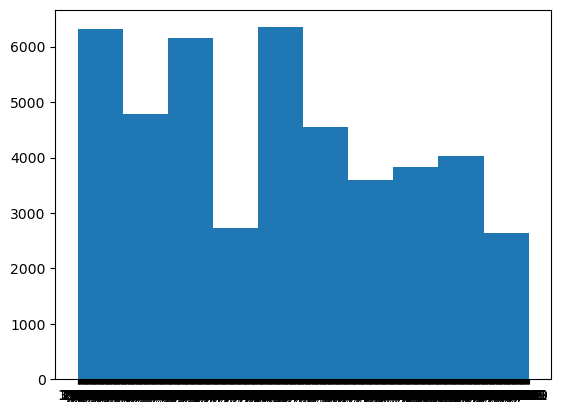

In [ ]:
plt.hist(df['Num of Reviews'])

(array([6310., 4784., 6163., 2732., 6349., 4556., 3596., 3834., 4035.,
        2641.]),
 array([  0. ,  84.3, 168.6, 252.9, 337.2, 421.5, 505.8, 590.1, 674.4,
        758.7, 843. ]),
 <BarContainer object of 10 artists>)

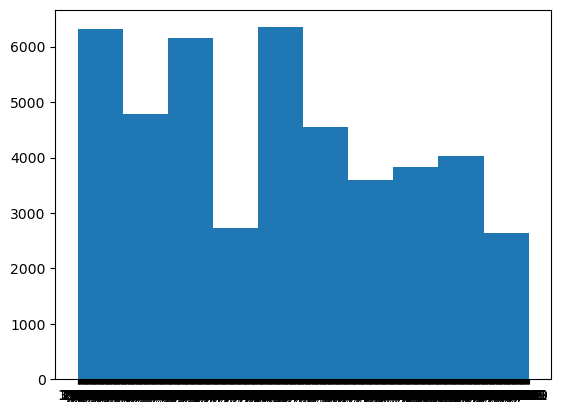

In [ ]:
plt.hist(df['Num of Reviews'])

(array([4.2840e+03, 1.9967e+04, 1.4859e+04, 4.5580e+03, 9.7400e+02,
        2.1300e+02, 5.9000e+01, 5.2000e+01, 7.0000e+00, 2.7000e+01]),
 array([  83.87681159,  185.28387681,  286.69094203,  388.09800725,
         489.50507246,  590.91213768,  692.3192029 ,  793.72626812,
         895.13333333,  996.54039855, 1097.94746377]),
 <BarContainer object of 10 artists>)

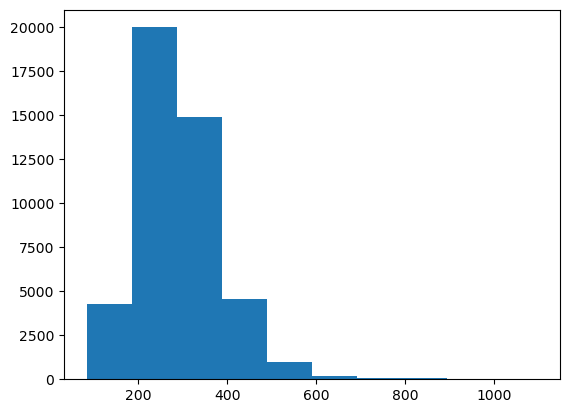

In [ ]:
plt.hist(df['Curr Price'])

In [ ]:
q1 = df['Curr Price'].quantile(0.25)
q3 = df['Curr Price'].quantile(0.75)
iqr = q3-q1
top_lim = q3 + 1.5*iqr
bottom_lim = q1 - 1.5* iqr
df = df.drop(df[df['Curr Price'] > top_lim].index)
df = df.drop(df[df['Curr Price'] < bottom_lim].index)

{'whiskers': [<matplotlib.lines.Line2D at 0x2b16c7aad30>,
 'caps': [<matplotlib.lines.Line2D at 0x2b16c7c4310>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b16b78b7f0>],
 'medians': [<matplotlib.lines.Line2D at 0x2b16c7c48b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b16c7c4b80>],
 'means': []}

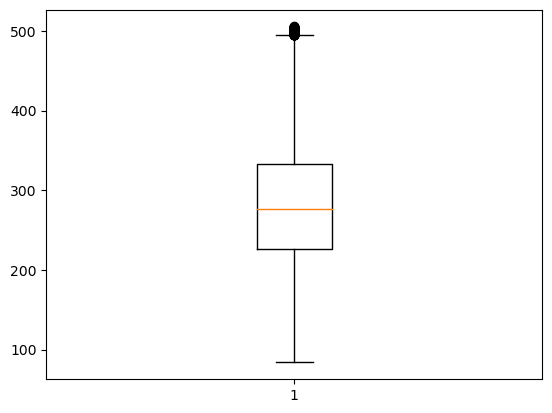

In [ ]:
plt.boxplot(df['Curr Price'])

In [ ]:
df

,Snapshot,Index,Hotel Name,TTT,LOS,Grade,Num of Reviews,Curr Price,Original Price,Distance from center,Type of room,Location grade,Free Cancellation,No prepayment needed,Breakfast included,Cancel Later
0,2023-03-06,1,Margaritaville Resort Times Square,0,1,8.8,"1,369",210.251208,210.251208,1500,Standard Queen Room,9.4,False,False,False,False
1,2023-03-06,2,33 Seaport Hotel New York,0,1,8.6,284,293.568841,293.568841,6900,Superior Courtyard King,-1,False,False,False,False
2,2023-03-06,3,The Belvedere Hotel,0,1,8.0,"3,644",142.590580,142.590580,900,Standard King Room,9.4,False,False,False,False
3,2023-03-06,4,CIVILIAN Hotel,0,1,8.5,"1,172",214.445048,214.445048,900,Double Room,9.5,False,False,False,False
4,2023-03-06,5,The Cloud One New York-Downtown,0,1,8.2,518,173.345411,173.345411,7000,Standard King Room,-1,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2023-03-10,96,Aloft Manhattan Downtown - Financial District,29,5,7.5,"1,106",214.780556,214.780556,6800,"Guest room, 1 Queen",-1,True,False,False,True
44996,2023-03-10,97,Hampton Inn Manhattan/Downtown- Financial Dist...,29,5,7.6,658,249.337802,249.337802,7700,Queen Room,-1,True,True,False,True
44997,2023-03-10,98,Leon Hotel LES,29,5,8.1,"1,309",301.844686,377.333816,5900,Superior Queen Room,-1,True,True,False,True
44998,2023-03-10,99,SoHo 54,29,5,6.9,"1,562",214.724638,238.545652,5300,SoHo King,-1,True,True,False,True
